In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD

import tensorflow as tf
from setup_mnist import MNIST
from setup_cifar import CIFAR
import os

def train(data, file_name, params, num_epochs=50, batch_size=128, train_temp=1, init=None):
    """
    Standard neural network training procedure.
    """
    model = Sequential()

    print(data.train_data.shape)
    
    model.add(Conv2D(params[0], (3, 3),
                            input_shape=data.train_data.shape[1:]))
    model.add(Activation('relu'))
    model.add(Conv2D(params[1], (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(params[2], (3, 3)))
    model.add(Activation('relu'))
    model.add(Conv2D(params[3], (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(params[4]))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(params[5]))
    model.add(Activation('relu'))
    model.add(Dense(10))
    
    if init != None:
        model.load_weights(init)

    def fn(correct, predicted):
        return tf.nn.softmax_cross_entropy_with_logits(labels=correct,
                                                       logits=predicted/train_temp)

    sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    
    model.compile(loss=fn,
                  optimizer=sgd,
                  metrics=['accuracy'])
    
    model.fit(data.train_data, data.train_labels,
              batch_size=batch_size,
              validation_data=(data.validation_data, data.validation_labels),
              nb_epoch=num_epochs,
              shuffle=True)
    

    if file_name != None:
        model.save(file_name)

    return model

def train_distillation(data, file_name, params, num_epochs=50, batch_size=128, train_temp=1):
    """
    Train a network using defensive distillation.
    Distillation as a Defense to Adversarial Perturbations against Deep Neural Networks
    Nicolas Papernot, Patrick McDaniel, Xi Wu, Somesh Jha, Ananthram Swami
    IEEE S&P, 2016.
    """
    if not os.path.exists(file_name+"_init"):
        # Train for one epoch to get a good starting point.
        train(data, file_name+"_init", params, 1, batch_size)
    
    # now train the teacher at the given temperature
    teacher = train(data, file_name+"_teacher", params, num_epochs, batch_size, train_temp,
                    init=file_name+"_init")

    # evaluate the labels at temperature t
    predicted = teacher.predict(data.train_data)
    with tf.Session() as sess:
        y = sess.run(tf.nn.softmax(predicted/train_temp))
        print(y)
        data.train_labels = y

    # train the student model at temperature t
    student = train(data, file_name, params, num_epochs, batch_size, train_temp,
                    init=file_name+"_init")

    # and finally we predict at temperature 1
    predicted = student.predict(data.train_data)

    print(predicted)

/home/tianwei/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
if not os.path.isdir('models'):
    os.makedirs('models')

# train(CIFAR(), "models/cifar", [64, 64, 128, 128, 256, 256], num_epochs=50)
train(MNIST(), "models/mnist", [32, 32, 64, 64, 200, 200], num_epochs=50)

train_distillation(MNIST(), "models/mnist-distilled-100", [32, 32, 64, 64, 200, 200],
                   num_epochs=50, train_temp=100)
# train_distillation(CIFAR(), "models/cifar-distilled-100", [64, 64, 128, 128, 256, 256],
#                    num_epochs=50, train_temp=100)

(55000, 28, 28, 1)


/home/tianwei/anaconda3/lib/python3.6/site-packages/keras/models.py:944: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 55000 samples, validate on 5000 samples
Epoch 1/50
55000/55000 [==============================] - 4s 75us/step - loss: 0.6842 - acc: 0.7719 - val_loss: 0.0860 - val_acc: 0.9740
Epoch 2/50
55000/55000 [==============================] - 4s 74us/step - loss: 0.1227 - acc: 0.9626 - val_loss: 0.0608 - val_acc: 0.9824
Epoch 3/50
55000/55000 [==============================] - 4s 73us/step - loss: 0.0869 - acc: 0.9734 - val_loss: 0.0484 - val_acc: 0.9870
Epoch 4/50
55000/55000 [==============================] - 4s 72us/step - loss: 0.0719 - acc: 0.9784 - val_loss: 0.0487 - val_acc: 0.9860
Epoch 5/50
55000/55000 [==============================] - 4s 73us/step - loss: 0.0614 - acc: 0.9825 - val_loss: 0.0426 - val_acc: 0.9884
Epoch 6/50
55000/55000 [==============================] - 4s 73us/step - loss: 0.0530 - acc: 0.9842 - val_loss: 0.0370 - val_acc: 0.9904
Epoch 7/50
55000/55000 [==============================] - 4s 71us/step - loss: 0.0464 - acc: 0.9851 - val_loss: 0.0379 - val_acc:

55000/55000 [==============================] - 4s 70us/step - loss: 0.0450 - acc: 0.9859 - val_loss: 0.0414 - val_acc: 0.9892
Epoch 13/50
55000/55000 [==============================] - 4s 73us/step - loss: 0.0405 - acc: 0.9875 - val_loss: 0.0420 - val_acc: 0.9896
Epoch 14/50
55000/55000 [==============================] - 4s 73us/step - loss: 0.0391 - acc: 0.9881 - val_loss: 0.0416 - val_acc: 0.9906
Epoch 15/50
55000/55000 [==============================] - 4s 74us/step - loss: 0.0375 - acc: 0.9883 - val_loss: 0.0417 - val_acc: 0.9892
Epoch 16/50
55000/55000 [==============================] - 4s 75us/step - loss: 0.0357 - acc: 0.9887 - val_loss: 0.0389 - val_acc: 0.9894
Epoch 17/50
55000/55000 [==============================] - 4s 75us/step - loss: 0.0344 - acc: 0.9893 - val_loss: 0.0425 - val_acc: 0.9892
Epoch 18/50
55000/55000 [==============================] - 4s 73us/step - loss: 0.0323 - acc: 0.9899 - val_loss: 0.0393 - val_acc: 0.9894
Epoch 19/50
55000/55000 [=====================

In [2]:
import tensorflow as tf
import numpy as np
import time

from setup_cifar import CIFAR, CIFARModel
from setup_mnist import MNIST, MNISTModel
from setup_inception import ImageNet, InceptionModel

from l2_attack import CarliniL2
from l0_attack import CarliniL0
from li_attack import CarliniLi


# def show(img):
#     """
#     Show MNSIT digits in the console.
#     """
#     remap = "  .*#"+"#"*100
#     img = (img.flatten()+.5)*3
#     if len(img) != 784: return
#     print("START")
#     for i in range(28):
#         print("".join([remap[int(round(x))] for x in img[i*28:i*28+28]]))


def generate_data(data, samples, targeted=True, start=0, inception=False):
    """
    Generate the input data to the attack algorithm.
    data: the images to attack
    samples: number of samples to use
    targeted: if true, construct targeted attacks, otherwise untargeted attacks
    start: offset into data to use
    inception: if targeted and inception, randomly sample 100 targets intead of 1000
    """
    inputs = []
    targets = []
    for i in range(samples):
        if targeted:
            if inception:
                seq = random.sample(range(1,1001), 10)
            else:
                seq = range(data.test_labels.shape[1])

            for j in seq:
                if (j == np.argmax(data.test_labels[start+i])) and (inception == False):
                    continue
                inputs.append(data.test_data[start+i])
                targets.append(np.eye(data.test_labels.shape[1])[j])
        else:
            inputs.append(data.test_data[start+i])
            targets.append(data.test_labels[start+i])

    inputs = np.array(inputs)
    targets = np.array(targets)

    return inputs, targets

In [4]:
# sess = tf.Session()
# tf.global_variables_initializer().run()
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.3)
sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))
# sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

data, model =  MNIST(), MNISTModel("models/mnist", sess)
# attack = CarliniL0(sess, model,  max_iterations=1000)
attack = CarliniL2(sess, model, batch_size=9, max_iterations=1000, confidence=0)

inputs, targets = generate_data(data, samples=1, targeted=True,
                                start=0, inception=False)

In [5]:
print(inputs.shape )
print(targets )

(9, 28, 28, 1)
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


In [6]:
timestart = time.time()
adv = attack.attack(inputs, targets)
timeend = time.time()

print("Took",timeend-timestart,"seconds to run",len(inputs),"samples.")

go up to 9
tick 0
[10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0]
0 (0.31689778, 0.30828923, 0.008608541)
100 (0.3096748, 0.30948365, 0.00019114162)
200 (0.30967465, 0.30948296, 0.00019170092)
[10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0]
0 (3.0915658, 3.0828648, 0.008701024)
100 (3.0796146, 3.0608106, 0.018804064)
200 (3.0795789, 3.060698, 0.018880896)
[10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0]
0 (30.837337, 30.828623, 0.008714739)
100 (29.135054, 27.609741, 1.5253124)
200 (29.047745, 27.312931, 1.7348135)
300 (27.853994, 24.818047, 3.0359473)
400 (27.040356, 22.421566, 4.6187906)
500 (26.883575, 22.128323, 4.755252)
600 (26.862684, 22.092396, 4.770289)
700 (26.845453, 22.015839, 4.8296146)
800 (26.842697, 22.015255, 4

In [7]:
%matplotlib inline
%load_ext autoreload

%autoreload 2
import matplotlib.pyplot as plt

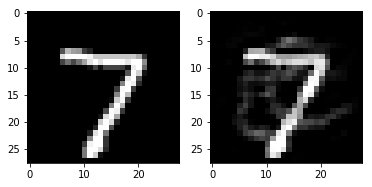

Score: [ 4.2657537  -0.9997887   2.5559726   4.047532   -4.4835215  -1.4104309
 -6.010616    4.260179    3.8235338  -0.16539659]
output:  0
Total distortion: 2.372663452820809


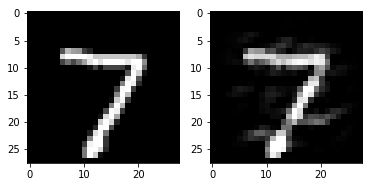

Score: [-1.9826359   6.06975     0.15967746  1.4313545   0.07984024 -0.07094501
 -2.7623541   6.068254   -2.9568162  -2.15004   ]
output:  1
Total distortion: 2.3508733709153926


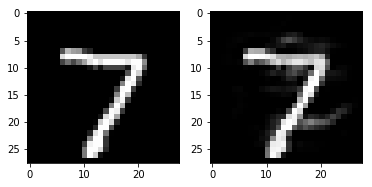

Score: [-0.82800776  1.3511279  14.390817    0.48425576  0.4990364  -6.9798026
 -8.417649   14.386946   -2.205412   -4.453898  ]
output:  2
Total distortion: 1.7001143276815562


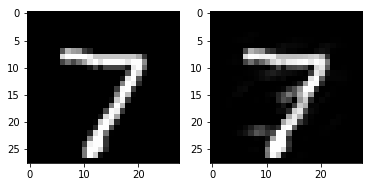

Score: [ -7.2008176   -0.41203493  -2.050197    16.544832    -4.2256393
   4.456963   -10.01653     16.54362     -3.738817     2.8305173 ]
output:  3
Total distortion: 1.4323547164448909


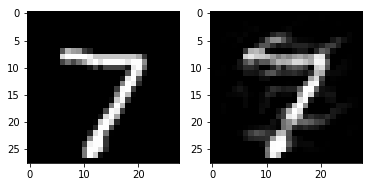

Score: [-2.1440659   1.685077    0.7468957   1.8213439   1.9354087  -1.182419
 -1.7374768   1.9311057   0.13006857 -0.01027034]
output:  4
Total distortion: 2.649005480151846


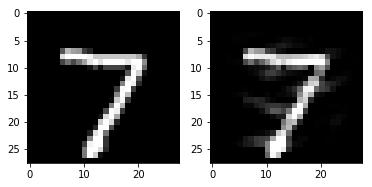

Score: [-6.4558115   0.02183625 -5.714462   11.429755   -3.4061081  11.63688
 -7.772034   11.629851   -2.9534466   5.4366794 ]
output:  5
Total distortion: 1.9146682714882362


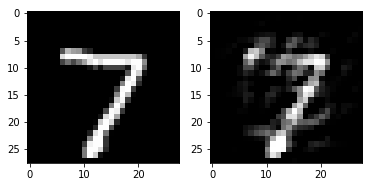

Score: [-0.05487125  0.59722966 -0.36207178  0.3655348   0.60296136  0.5931034
  0.6062752   0.5950163   0.6018177  -1.1093677 ]
output:  6
Total distortion: 3.418462017978169


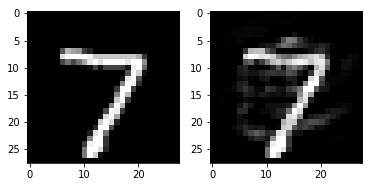

Score: [-0.90495545 -0.58276975  1.0549864   4.3603983  -2.9060047  -1.4197865
 -6.3986325   4.3466883   4.3856325   4.380493  ]
output:  8
Total distortion: 2.2433832150374395


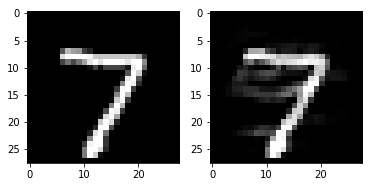

Score: [ -5.587811   -1.8828247  -5.5686703  14.046708   -3.194115    4.616238
 -12.546566   14.142854   -2.1650891  14.151437 ]
output:  9
Total distortion: 1.9142030625404616


In [8]:


for org_img, adv_img in zip(inputs, adv):
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(np.reshape(org_img, (28,28)), cmap="gray")
    plt.subplot(1,2,2)
    plt.imshow(np.reshape(adv_img, (28,28)), cmap="gray")
#     plt.colorbar()
    plt.show()
    pred_score = model.model.predict(adv_img.reshape( (1,adv_img.shape[0],adv_img.shape[1],adv_img.shape[2] )))
    print("Score:",pred_score[0])
    print('output: ', np.argmax(pred_score[0]) )
    print("Total distortion:", np.sum((adv_img-org_img)**2)**.5)
    
#     break

In [ ]:
# for i in range(len(adv)):
#     print("Valid:")
#     show(inputs[i])
#     print("Adversarial:")
#     show(adv[i])

#     print("Classification:", model.model.predict(adv[i:i+1]))

#     print("Total distortion:", np.sum((adv[i]-inputs[i])**2)**.5)